#IMPORTAR MODULOS

In [14]:
#@title
# Import Python Modules

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

# access to data
import io
import os
from os import listdir
from os.path import isfile, join

# data manipulation
import pandas as pd
import numpy as np
from PIL import Image

# scipy images
from scipy.ndimage import rotate
import scipy.stats as st
import scipy

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
import multiprocessing
from joblib import delayed, Parallel

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# time and random code
import time
import random

# model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

device = "cuda"

### limpiar la memoria
import gc
gc.collect()
torch.cuda.empty_cache()

# Data Import 

In [15]:
# Import Drive to access the files

current_path = os.getcwd()
print(current_path)

# Access the files
main_project_folder = current_path
csv_folder = 'PruneCXR'
img_folder = 'images'

csv_train_path = os.path.join(main_project_folder, csv_folder, 'miccai2023_nih-cxr-lt_labels_train_02.csv')
csv_test_path = os.path.join(main_project_folder, csv_folder, 'miccai2023_nih-cxr-lt_labels_test_02.csv')
csv_val_path = os.path.join(main_project_folder, csv_folder, 'miccai2023_nih-cxr-lt_labels_val_02.csv')

images = os.path.join(main_project_folder, img_folder)

# Read Files and load them as pd dataframes
train = pd.read_csv(csv_train_path)
test = pd.read_csv(csv_test_path)
val = pd.read_csv(csv_val_path)

train

d:\Documentos\Datascience\machine_learning2\lung dissese


,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subj_id
0,00000101_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101
1,00000102_000.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,102
2,00000103_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,103
3,00000103_001.png,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,103
4,00000103_002.png,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3537,00001335_002.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1335
3538,00001335_003.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1335
3539,00001335_004.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1335
3540,00001335_005.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1335


## Hyperparameter Settings

In [16]:
n_epochs = 3
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.5

# Data Augmentation & Loader

In [17]:
class Affection(Dataset):
    def __init__(self, img_dir, dataframe, transform=None):
        self.X = img_dir

        self.y = dataframe

        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_id = self.y.iloc[idx,0]
        relevant_row = self.y.iloc[idx, [i for i in range(self.y.shape[1]) if i not in [0, 20, 21]]]
        labels = torch.tensor(relevant_row)

        image_path = self.X+'/'+img_id
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, labels

In [18]:
transform = transforms.Compose([
        transforms.CenterCrop(790),         # Randomly crop the image to 400x400
        #transforms.Resize((500, 500)),       # Resize the image
        transforms.RandomRotation(5),      # Rotate the image by up to 5 degrees
        transforms.ColorJitter(brightness=0.2, hue=0.2, saturation=0.2),           # Randomly change brightness, contrast, saturation, and hue
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
    ])

In [19]:
dataset_train = Affection(images, train, transform=transform)
dataset_test = Affection(images, test, transform=transform)
print(len(dataset_train[0][1]))

train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False)


19


In [20]:
torch.manual_seed(0)

# Implementing basic convolution Neural Network

In [21]:
# Definir una red neuronal convolutiva modificada para tus datos
class AffectionsCNN(nn.Module):
    def __init__(self, block, layers, num_classes=19):
        super(AffectionsCNN, self).__init__()
        self.in_channels = 64

        # Capa inicial
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Capas residuales
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        # Capa global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Capa completamente conectada
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, block, channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, channels, stride))
        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Definir la función de bloque básico para ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out
    
    ###### Red convolucional simple
    # def __init__(self):
    #     super(AffectionsCNN, self).__init__()
    #     self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    #     self.relu1 = nn.ReLU()
    #     self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    #     self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    #     self.relu2 = nn.ReLU()
    #     self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    #     self.flatten = nn.Flatten()
    #     self.fc1 = nn.Linear(64 * 125 * 125, 128)
    #     self.relu3 = nn.ReLU()
    #     self.fc2 = nn.Linear(128, 19)

    # def forward(self, x):
    #     x = self.pool1(self.relu1(self.conv1(x)))
    #     x = self.pool2(self.relu2(self.conv2(x)))
    #     x = self.flatten(x)
    #     x = self.relu3(self.fc1(x))
    #     x = self.fc2(x)
    #     return x


In [22]:

## Para ResNet es necesario definir un bloque básico y una función de bloque básico
model = AffectionsCNN(BasicBlock, [2, 2, 2]).to(device)
print(model)

# sample_data = dataset_train[0][0].unsqueeze(0).to(device)
# print(sample_data)

# output_model = model(sample_data)
# print(output_model.size())

AffectionsCNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()


In [23]:
# Definir la función de pérdida y el optimizador
loss_function = nn.CrossEntropyLoss() # nn.BCEWithLogitsLoss() # 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Optimizer Loop

In [24]:
# Note: network.train() puts the network into "nondeterministic mode".
def train(network, optimizer, epoch, log_interval = 3):
  network.train()
  loss_logs = list()

  for batch_idx, (data, target) in enumerate(train_loader):
    num_batches = len(train_loader)
    size = len(train_loader.dataset)

    # To account for GPU
    data, target = data.to(device), target.to(device)

    target = target.float()

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    output = network(data)

    # Compute loss - Use the negative log likelihood loss function
    loss = loss_function(output, target)

    # Perform backpropagation - gradient update
    loss.backward()

    # Perform optimization
    optimizer.step()

    # print an update
    if batch_idx % log_interval == 0:
      examples_shown = batch_idx * len(data)
      total_examples = len(train_loader.dataset)
      fraction_shown = round(examples_shown / total_examples * 100., 2)
      rounded_loss = round(loss.item(), 4)
      print(f'Train Epoch {epoch} Progress: {fraction_shown}%\tLoss: {rounded_loss}')

      examples_so_far = batch_idx*batch_size + epoch*len(train_loader.dataset)
      loss_logs.append((examples_so_far, loss.item()))
  return loss_logs

In [25]:
from tqdm import tqdm

def test(network):
    network.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            target = target.float()
            # To account for GPU
            data, target = data.to(device), target.to(device)
            output = network(data)
            #test_loss += loss_function(output, target).item()
            test_loss += loss_function(output, target).item()            

            # Threshold predictions for binary classification
            pred = output >= 0.5
            correct += pred.eq(target.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    #accuracy = round(100. * correct.item() / len(test_loader.dataset), 2)
    accuracy = round(100. * correct.item() / (test_loader.dataset[0][1].shape[-1] * len(test_loader.dataset)), 2)
    print(f'\nTest set: Avg loss {round(test_loss, 4)}, Accuracy {accuracy}%\n')
    return test_loss, accuracy

In [26]:
test_accuracies, test_losses, train_losses = list(), list(), list()
total_examples_seen = 0

for epoch in range(n_epochs):
  test_loss, test_accuracy = test(model)
  train_loss_logs = train(model, optimizer, epoch)
  # logging
  test_accuracies.append((epoch, test_accuracy))
  test_losses.append((total_examples_seen, test_loss))
  train_losses.extend((train_loss_logs))
  total_examples_seen = train_loss_logs[-1][0]

test_loss, test_accuracy = test(model)
test_accuracies.append((n_epochs, test_accuracy))
test_losses.append((total_examples_seen, test_loss))

100%|██████████| 24/24 [00:30<00:00,  1.29s/it]



Test set: Avg loss 0.0974, Accuracy 94.54%

Train Epoch 0 Progress: 0.0%	Loss: 3.1664
Train Epoch 0 Progress: 2.71%	Loss: 2.8107
Train Epoch 0 Progress: 5.42%	Loss: 1.9625
Train Epoch 0 Progress: 8.13%	Loss: 1.5645
Train Epoch 0 Progress: 10.84%	Loss: 1.4256
Train Epoch 0 Progress: 13.55%	Loss: 1.3424
Train Epoch 0 Progress: 16.26%	Loss: 1.5802
Train Epoch 0 Progress: 18.97%	Loss: 2.2407
Train Epoch 0 Progress: 21.68%	Loss: 3.1487
Train Epoch 0 Progress: 24.39%	Loss: 1.2138
Train Epoch 0 Progress: 27.1%	Loss: 1.388
Train Epoch 0 Progress: 29.81%	Loss: 1.1436
Train Epoch 0 Progress: 32.52%	Loss: 0.7259
Train Epoch 0 Progress: 35.23%	Loss: 2.7547
Train Epoch 0 Progress: 37.94%	Loss: 0.665
Train Epoch 0 Progress: 40.65%	Loss: 1.9293
Train Epoch 0 Progress: 43.37%	Loss: 0.468
Train Epoch 0 Progress: 46.08%	Loss: 1.2676
Train Epoch 0 Progress: 48.79%	Loss: 0.6006
Train Epoch 0 Progress: 51.5%	Loss: 1.4683
Train Epoch 0 Progress: 54.21%	Loss: 1.4632
Train Epoch 0 Progress: 56.92%	Loss: 3.66

100%|██████████| 24/24 [00:37<00:00,  1.54s/it]



Test set: Avg loss 0.088, Accuracy 81.36%

Train Epoch 1 Progress: 0.0%	Loss: 2.8499
Train Epoch 1 Progress: 2.71%	Loss: 2.6041
Train Epoch 1 Progress: 5.42%	Loss: 1.8338
Train Epoch 1 Progress: 8.13%	Loss: 1.5415
Train Epoch 1 Progress: 10.84%	Loss: 1.3579
Train Epoch 1 Progress: 13.55%	Loss: 1.3482
Train Epoch 1 Progress: 16.26%	Loss: 1.5054
Train Epoch 1 Progress: 18.97%	Loss: 2.2096
Train Epoch 1 Progress: 21.68%	Loss: 3.1174
Train Epoch 1 Progress: 24.39%	Loss: 1.1543
Train Epoch 1 Progress: 27.1%	Loss: 1.2951
Train Epoch 1 Progress: 29.81%	Loss: 1.1375
Train Epoch 1 Progress: 32.52%	Loss: 0.7305
Train Epoch 1 Progress: 35.23%	Loss: 2.5852
Train Epoch 1 Progress: 37.94%	Loss: 0.649
Train Epoch 1 Progress: 40.65%	Loss: 1.8933
Train Epoch 1 Progress: 43.37%	Loss: 0.4225
Train Epoch 1 Progress: 46.08%	Loss: 1.227
Train Epoch 1 Progress: 48.79%	Loss: 0.604
Train Epoch 1 Progress: 51.5%	Loss: 1.4744
Train Epoch 1 Progress: 54.21%	Loss: 1.4579
Train Epoch 1 Progress: 56.92%	Loss: 3.818

100%|██████████| 24/24 [00:37<00:00,  1.54s/it]



Test set: Avg loss 0.085, Accuracy 83.36%

Train Epoch 2 Progress: 0.0%	Loss: 2.7927
Train Epoch 2 Progress: 2.71%	Loss: 2.5685
Train Epoch 2 Progress: 5.42%	Loss: 1.812
Train Epoch 2 Progress: 8.13%	Loss: 1.5189
Train Epoch 2 Progress: 10.84%	Loss: 1.3707
Train Epoch 2 Progress: 13.55%	Loss: 1.3781
Train Epoch 2 Progress: 16.26%	Loss: 1.5418
Train Epoch 2 Progress: 18.97%	Loss: 2.2263
Train Epoch 2 Progress: 21.68%	Loss: 3.1115
Train Epoch 2 Progress: 24.39%	Loss: 1.1524
Train Epoch 2 Progress: 27.1%	Loss: 1.2957
Train Epoch 2 Progress: 29.81%	Loss: 1.1182
Train Epoch 2 Progress: 32.52%	Loss: 0.7488
Train Epoch 2 Progress: 35.23%	Loss: 2.5457
Train Epoch 2 Progress: 37.94%	Loss: 0.6505
Train Epoch 2 Progress: 40.65%	Loss: 1.8488
Train Epoch 2 Progress: 43.37%	Loss: 0.4096
Train Epoch 2 Progress: 46.08%	Loss: 1.2215
Train Epoch 2 Progress: 48.79%	Loss: 0.611
Train Epoch 2 Progress: 51.5%	Loss: 1.5138
Train Epoch 2 Progress: 54.21%	Loss: 1.4524
Train Epoch 2 Progress: 56.92%	Loss: 3.71

100%|██████████| 24/24 [00:37<00:00,  1.56s/it]


Test set: Avg loss 0.0855, Accuracy 82.28%



In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(test_accuracies, test_losses, train_losses):
  # plot training losses and test losses together
  training_x_values = [x[0] for x in train_losses]
  training_losses = [x[1] for x in train_losses]
  plt.plot(training_x_values, training_losses)
  test_x_values = [x[0]  for x in test_losses]
  test_loss_values = [x[1] for x in test_losses]
  plt.plot(test_x_values, test_loss_values, linestyle='--', marker='o', color='r')
  # plt.scatter(test_x_values, test_loss_values, color='r')
  plt.ylabel('Cross Entropy Train loss')
  plt.xlabel('Examples seen')
  plt.show()

  # Next, plot test accuracy over time
  test_accuracy_x_values = [x[0] for x in test_accuracies]
  test_accuracy_values = [x[1] for x in test_accuracies]
  plt.plot(test_accuracy_x_values, test_accuracy_values, color='g', marker='o')
  plt.ylabel('Test Accuracy')
  plt.xlabel('Epochs')

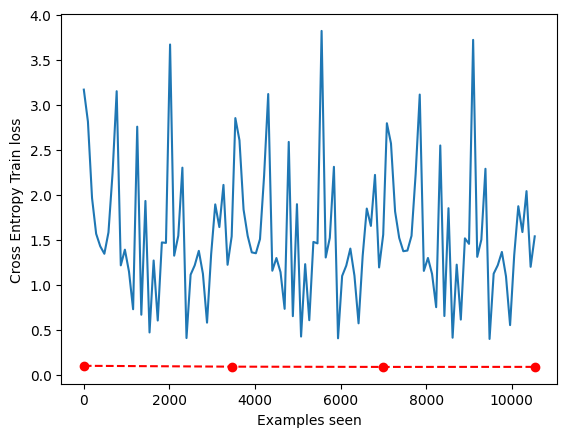

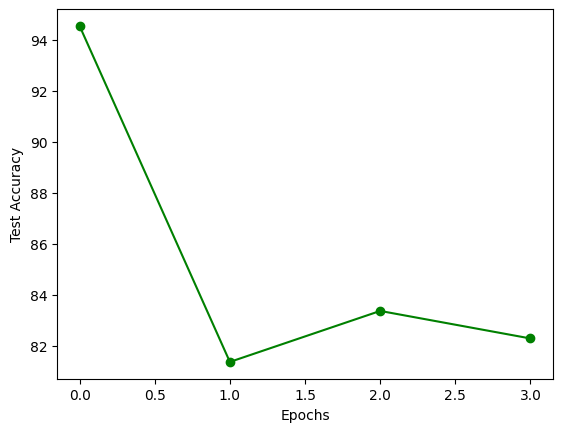

In [28]:
plot_results(test_accuracies, test_losses, train_losses)

# Sanity check  

In [29]:
def visualize_prediction(datapoint, model):
  to_pil = transforms.ToPILImage()
  image = to_pil(datapoint[0])
  plt.imshow(image)

  datapoint = datapoint[0].unsqueeze(0).to(device)

#   title = 'Model Predicts Tuberculosis' if model(datapoint[0]) > 0.5 else 'Model Predicts Healthy'
#   subtitle = '(True label Tuberculosis)' if datapoint[1] else '(True label Healthy)'
#   plt.title(title + '\n' + subtitle)
#   plt.axis('off')
#   plt.show()


# visualize_prediction(dataset_test[0], model)
# visualize_prediction(dataset_test[1], model)
# visualize_prediction(dataset_test[2], model)
# visualize_prediction(dataset_test[3], model)
# visualize_prediction(dataset_test[4], model)
# visualize_prediction(dataset_test[-1], model)
# visualize_prediction(dataset_test[-2], model)
# visualize_prediction(dataset_test[-3], model)
# visualize_prediction(dataset_test[-4], model)
# visualize_prediction(dataset_test[-5], model)